## Import

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.timeseries import LombScargle

In [8]:
FILENAME = r'data_cleaned/all_mid_time_data_with_OC.csv'
df = pd.read_csv(FILENAME)
df.tail(3)

,Planet,Tmid_(BJD_TDB),Tmid_unc.,source,P_(days),P_unc.,epoch,O-C_(days),O-C_unc._(days)
30341,piMenc,2.460149e+06,0.00084,space,6.267821,0.000001,122,0.000897,0.001149
30342,piMenc,2.460156e+06,0.00095,space,6.267821,0.000001,123,0.000166,0.001260
30343,piMenc,2.460175e+06,0.00110,space,6.267821,0.000001,126,0.000004,0.001414


## Outlier rejection (5-sigma clipping)

In [12]:
def sigma_clip_OC(df, sigma=5):
    mu = df.groupby('Planet')['O-C_(days)'].transform('mean')
    std = df.groupby('Planet')['O-C_(days)'].transform('std')

    mask = (df['O-C_(days)'] - mu).abs() <= sigma * std
    return df.loc[mask].reset_index(drop=True)

df_clip = sigma_clip_OC(df)
df_clip.tail(3)

,Planet,Tmid_(BJD_TDB),Tmid_unc.,source,P_(days),P_unc.,epoch,O-C_(days),O-C_unc._(days)
30278,piMenc,2.460149e+06,0.00084,space,6.267821,0.000001,122,0.000897,0.001149
30279,piMenc,2.460156e+06,0.00095,space,6.267821,0.000001,123,0.000166,0.001260
30280,piMenc,2.460175e+06,0.00110,space,6.267821,0.000001,126,0.000004,0.001414


## Periodicity search (GLS)

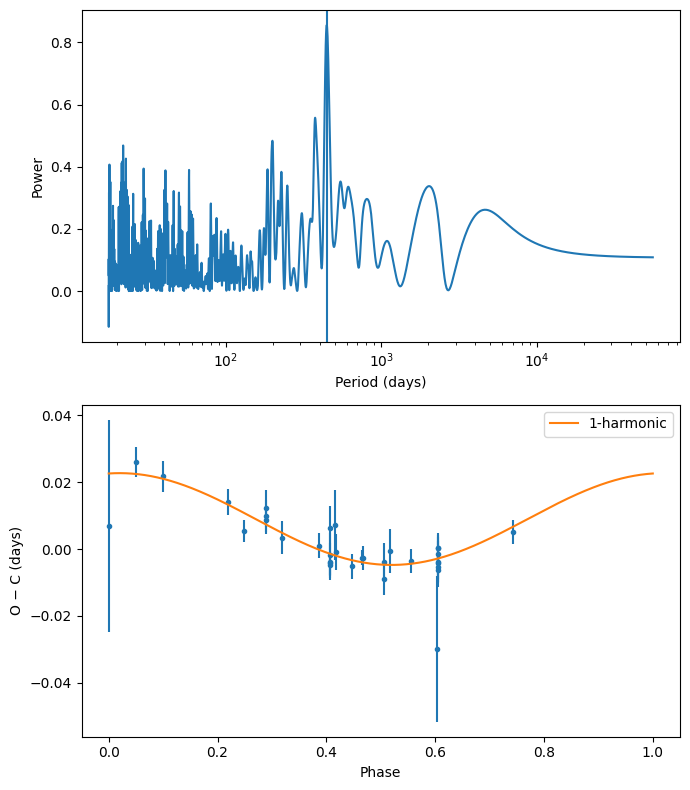

In [59]:
def lomb_scargle_analysis(df, N_freq=10000):
    # Frequency grid
    Tmid = df['Tmid_(BJD_TDB)']
    Porb = df['P_(days)'].mode().iloc[0]
    OC = df['O-C_(days)']
    OCerr = df['O-C_unc._(days)']
    
    baseline = Tmid.max() - Tmid.min()
    freq = np.linspace(1 / (10*baseline), 1 / (2*Porb), N_freq)

    # Lomb–Scargle (1-harmonic model)
    ls1 = LombScargle(Tmid, OC, OCerr, nterms=1)
    power = ls1.power(freq)
    # Best frequency -> period -> amplitude 
    f_best = freq[np.argmax(power)]
    period = 1 / f_best
    
    model1 = ls1.model(Tmid, f_best)
    amp1 = 0.5 * (model1.max() - model1.min())

    # Lomb–Scargle (2-harmonic model)
    ls2 = LombScargle(Tmid, OC, OCerr, nterms=2)
    model2 = ls2.model(Tmid, f_best)
    amp2 = 0.5 * (model2.max() - model2.min())

    # False Alarm Probability / FAP at 5%, 1%, 0.1% and min (best period)
    fap = ls1.false_alarm_probability(power.max())
    fap5 = ls1.false_alarm_level(0.05); fap1 = ls1.false_alarm_level(0.01); fap01 = ls1.false_alarm_level(0.001); 

    # # BIC (TBA)
    # resid1 = y - model1
    # resid2 = y - model2
    # n = len(y)
    # k1, k2 = 3, 5  # offset + sin/cos terms
    # bic1 = n * np.log(np.var(resid1)) + k1 * np.log(n)
    # bic2 = n * np.log(np.var(resid2)) + k2 * np.log(n)
    
    # Phase
    t_fit = np.linspace(Tmid.min(), Tmid.max(), 2000)
    phase = ((Tmid - Tmid.min()) / period) % 1
    phase_fit = ((t_fit - Tmid.min()) / period) % 1
    
    # Sort model by phase
    idx = np.argsort(phase_fit)
    phase_s = phase_fit[idx]
    model1_s = ls1.model(t_fit, f_best)[idx]
    model2_s = ls2.model(t_fit, f_best)[idx]
    
    # Break wrap-around at phase = 1 → 0
    breaks = np.where(np.diff(phase_s) < 0)[0] + 1
    phase_s = np.insert(phase_s, breaks, np.nan)
    model1_s = np.insert(model1_s, breaks, np.nan)
    model2_s = np.insert(model2_s, breaks, np.nan)
    
    # Plot
    fig, ax = plt.subplots(2, 1, figsize=(7, 8))
    
    ax[0].plot(1 / freq, power)
    ax[0].axvline(period)
    ax[0].set_xlabel("Period (days)")
    ax[0].set_ylabel("Power")
    ax[0].set_xscale("log")
    
    ax[1].errorbar(phase, OC, OCerr, fmt='.', zorder=1)
    ax[1].plot(phase_s, model1_s, label='1-harmonic', zorder=2)
    # ax[1].plot(phase_s, model2_s, '--', label='2-harmonic', zorder=2)
    
    ax[1].set_xlabel("Phase")
    ax[1].set_ylabel("O − C (days)")
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # return {
    #     "period": period,
    #     "amplitude_1harm": amp1,
    #     "amplitude_2harm": amp2,
    #     "BIC_1harm": bic1,
    #     "BIC_2harm": bic2,
    #     "FAP": fap,
    # }

test = df[df.Planet == 'WASP-148b']
lomb_scargle_analysis(test)